### Imports

In [1]:
# imports
import numpy as np

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

from tqdm.notebook import tqdm

# Seaborn style for visualization
sns.set_theme(style="whitegrid")

### Dataset and dataloader setup

In [2]:
# Set up data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5 and std=0.5
])

# Download and load the MNIST dataset
dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, transform=transform, download=True)

In [3]:
# Split the training dataset into train and validation subsets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Visualising images

In [4]:
# Function to visualize a batch of images
def visualize_images(dataloader, title="Images"):
    # Get a batch of images
    images, labels = next(iter(dataloader))
    
    # Denormalize images for visualization
    images = images * 0.5 + 0.5  # Reverse normalization to [0, 1]
    
    # Set up the figure
    fig, axes = plt.subplots(2, 4, figsize=(8, 4))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    
    for img, label, ax in zip(images[:8], labels[:8], axes):
        ax.imshow(img.squeeze(), cmap='gray')  # Display the single-channel image
        ax.set_title(f"Label: {label.item()}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

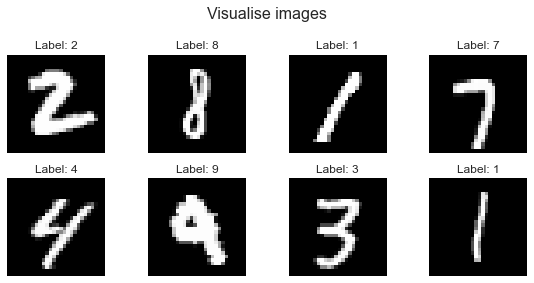

In [5]:
# Visualize train, validation, and test batches
visualize_images(train_loader, title="Visualise images")

### Baseline B-CNN

In [6]:
def KL_DIV(mu_q, sig_q, mu_p, sig_p):
    # print("mu_p", mu_p.shape)
    # print("mu_q", mu_q)
    # print("sig_p", sig_p.shape)
    # print("sig_q", sig_q)
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).mean()
    # print(kl.item())
    return kl

class BBBConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, priors=None):

        super(BBBConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = 1
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu = nn.Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))
        self.W_rho = nn.Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))

        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        if self.training or sample:
            W_eps = torch.empty(self.W_mu.size()).normal_(0, 1).to(self.device)
            self.W_sigma = torch.log1p(torch.exp(self.W_rho))
            weight = self.W_mu + W_eps * self.W_sigma
        else:
            weight = self.W_mu

        return F.conv2d(input, weight, None, self.stride, self.padding, self.dilation, self.groups)

    def kl_loss(self):
        return KL_DIV(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)

class BBBLinear(nn.Module):
    def __init__(self, in_features, out_features, priors=None):
        super(BBBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu = nn.Parameter(torch.empty((out_features, in_features), device=self.device))
        self.W_rho = nn.Parameter(torch.empty((out_features, in_features), device=self.device))
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        if self.training or sample:
            W_eps = torch.empty(self.W_mu.size()).normal_(0, 1).to(self.device)
            self.W_sigma = torch.log1p(torch.exp(self.W_rho))
            weight = self.W_mu + W_eps * self.W_sigma
        else:
            weight = self.W_mu

        return F.linear(input, weight, None)

    def kl_loss(self):
        return KL_DIV(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)

class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()
        self.conv1 = BBBConv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = BBBConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = BBBLinear(64 * 14 * 14, 128)
        self.fc2 = BBBLinear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        kl = 0.0
        for module in self.children():
            if hasattr(module, 'kl_loss'):
                module_kl_loss = module.kl_loss()
                # print("Inside BCNN", module_kl_loss.shape)
                kl = kl + module_kl_loss

        return x, kl

class NonBayesianCNN(nn.Module):
    def __init__(self):
        super(NonBayesianCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### Train and evaluate

In [7]:
def evaluate(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        # with tqdm(data_loader, unit="batch") as tepoch:
        #     tepoch.set_description("Evaluating")
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            if len(outputs) == 2: outputs = outputs[0]

            # Compute predictions and update accuracy metrics
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Display current accuracy in the progress bar
            accuracy = 100 * correct / total
    accuracy = 100 * correct / total  # Overall accuracy
    return accuracy

def train_validate_and_evaluate(model, optimizer, device, epochs, train_loader, test_loader, val_loader, criterion=None, use_kl=True):
    # Total number of batches across all epochs
    total_steps = len(train_loader) * epochs
    losses = []
    val_accuracies = []

    # Single progress bar for all epochs
    with tqdm(total=total_steps, unit="batch") as pbar:
        for epoch in range(epochs):
            model.train()
            total_combined_loss = 0.0
            
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                
                # One-hot encode labels
                one_hot_labels = F.one_hot(labels, num_classes=10).float()
                
                # Forward pass
                outputs = model(images)
                if len(outputs) == 2:
                    logits, kl_loss = outputs
                else:
                    logits = outputs
                
                # Apply softmax to logits
                softmax_outputs = F.softmax(logits, dim=1)
                
                # Cross-entropy loss with one-hot labels
                combined_loss = 0.0
                if criterion: combined_loss += criterion(softmax_outputs, one_hot_labels)
                if use_kl: combined_loss += kl_loss
                
                # Backward pass
                optimizer.zero_grad()
                combined_loss.backward()
                optimizer.step()
                
                # Update metrics
                total_combined_loss += combined_loss.item()
                
                # Update the progress bar dynamically
                pbar.set_description(f"Epoch {epoch + 1}/{epochs}")
                pbar.set_postfix(combined_loss=combined_loss.item())
                pbar.update(1)
            
            avg_combined_loss = total_combined_loss / len(train_loader)
            losses.append(avg_combined_loss)
            print(f"Epoch {epoch + 1}/{epochs}, Avg Combined Loss: {avg_combined_loss:.4f}")
            val_acc = evaluate(model, val_loader, device)
            val_accuracies.append(val_acc)
            print(f"Val Acc: {val_acc:.2f}%")

    print("Training complete.")

    test_acc = evaluate(model, test_loader, device)
    print(f"Testing complete. Test Acc: {test_acc:.2f}%")

    # Create a line plot
    sns.lineplot(x=np.arange(epochs), y=losses)

    # Add labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epoch")

    # Show the plot
    plt.show()

    # Create a line plot
    sns.lineplot(x=np.arange(epochs), y=val_accuracies)

    # Add labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy")
    plt.title("Val Accuracy vs. Epoch")

    # Show the plot
    plt.show()

### Train Non Bayesian CNN

  0%|          | 0/7500 [00:00<?, ?batch/s]

Epoch 1/10, Avg Combined Loss: 1.5518
Val Acc: 97.48%
Epoch 2/10, Avg Combined Loss: 1.4844
Val Acc: 97.84%
Epoch 3/10, Avg Combined Loss: 1.4788
Val Acc: 97.93%
Epoch 4/10, Avg Combined Loss: 1.4777
Val Acc: 98.12%
Epoch 5/10, Avg Combined Loss: 1.4748
Val Acc: 98.16%
Epoch 6/10, Avg Combined Loss: 1.4724
Val Acc: 98.32%
Epoch 7/10, Avg Combined Loss: 1.4712
Val Acc: 98.45%
Epoch 8/10, Avg Combined Loss: 1.4711
Val Acc: 98.12%
Epoch 9/10, Avg Combined Loss: 1.4707
Val Acc: 98.39%
Epoch 10/10, Avg Combined Loss: 1.4710
Val Acc: 98.59%
Training complete.
Testing complete. Test Acc: 98.56%


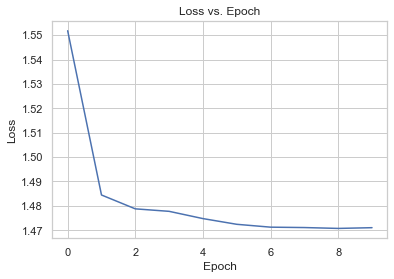

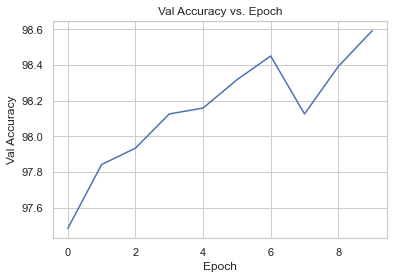

In [8]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, optimizer, and loss function
model = NonBayesianCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_validate_and_evaluate(model, optimizer, device, epochs, train_loader, test_loader, val_loader, criterion=criterion, use_kl=False)

### Train Bayesian CNN

  0%|          | 0/7500 [00:00<?, ?batch/s]

Epoch 1/10, Avg Combined Loss: 4.9407
Val Acc: 70.47%
Epoch 2/10, Avg Combined Loss: 2.4074
Val Acc: 81.80%
Epoch 3/10, Avg Combined Loss: 2.0278
Val Acc: 84.17%
Epoch 4/10, Avg Combined Loss: 1.9138
Val Acc: 84.78%
Epoch 5/10, Avg Combined Loss: 1.8649
Val Acc: 85.98%
Epoch 6/10, Avg Combined Loss: 1.8309
Val Acc: 84.62%
Epoch 7/10, Avg Combined Loss: 1.8130
Val Acc: 85.02%
Epoch 8/10, Avg Combined Loss: 1.7971
Val Acc: 84.47%
Epoch 9/10, Avg Combined Loss: 1.7905
Val Acc: 85.56%
Epoch 10/10, Avg Combined Loss: 1.7834
Val Acc: 86.47%
Training complete.
Testing complete. Test Acc: 87.46%


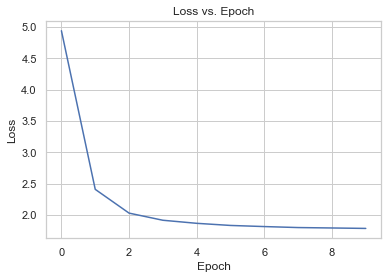

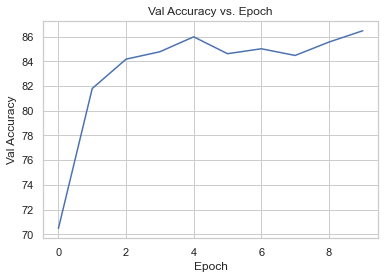

In [9]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, optimizer, and loss function
model = BayesianCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_validate_and_evaluate(model, optimizer, device, epochs, train_loader, test_loader, val_loader, criterion=criterion, use_kl=True)